In [1]:
%load_ext autoreload
%autoreload 2

In [181]:
from __future__ import print_function
import IPython
#
import os, sys, math
import time
import numpy as np
#import pandas as pd
import sklearn as skl
import statistics
from sklearn.neighbors import NearestNeighbors, DistanceMetric
#from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import scipy.special as sp
#
import eknn
from wrap import *

#pretty plots if seaborn is installed
try: 
    import seaborn as sns
    sns.set(style='ticks', palette='Set2',font_scale=1.5)
    #sns.set() 
except:
    pass

%matplotlib inline

## PyStan example

In [177]:
import pystan

# First we will write our Baysian model using
# Stan code. 
# We will then define our data and call pystan 
# to do MCMC sampling using NUT sampler
# 
mvgauss_code="""
data {
  int<lower=1> N;
  vector[N] v;
  vector[N] y;
}
parameters {
  vector[N] mu; 
}
transformed parameters {  
  cov_matrix[N] Sigma;
  for (i in 1:N) 
    for (j in 1:N)
      Sigma[i,j] <- 0 + if_else(i==j, v[i], 0.0);
}
model {
  increment_log_prob(multi_normal_log(y,mu,Sigma));
  // y ~ multi_normal(mu,Sigma); //drops constants
}
"""

# Define data model: we will use 10-dimensional Gaussian
# as given in the alan_eg
dmv=eknn.alan_eg()
mvgauss_dat={'y':dmv.mean_sample,
             'v':dmv.sigma_mean**2,
             'N':dmv.ndim}

# Intialize pystan -- this will convert our pystan code into C++
# and run MCMC
fit = pystan.stan(model_code=mvgauss_code, data=mvgauss_dat,
                  iter=1000, chains=4)


mean_sample= [  1.00015762   1.99377718   3.00039052   3.99959145   5.00040577
   6.00215849   7.00157911   7.9988785    9.00358661  10.00236275]
std_sample= [ 0.99840612  0.99544944  0.99662964  1.00416299  0.99674755  0.99973467
  0.99909627  0.99971631  0.99709372  0.99736724]



(200000, 10)


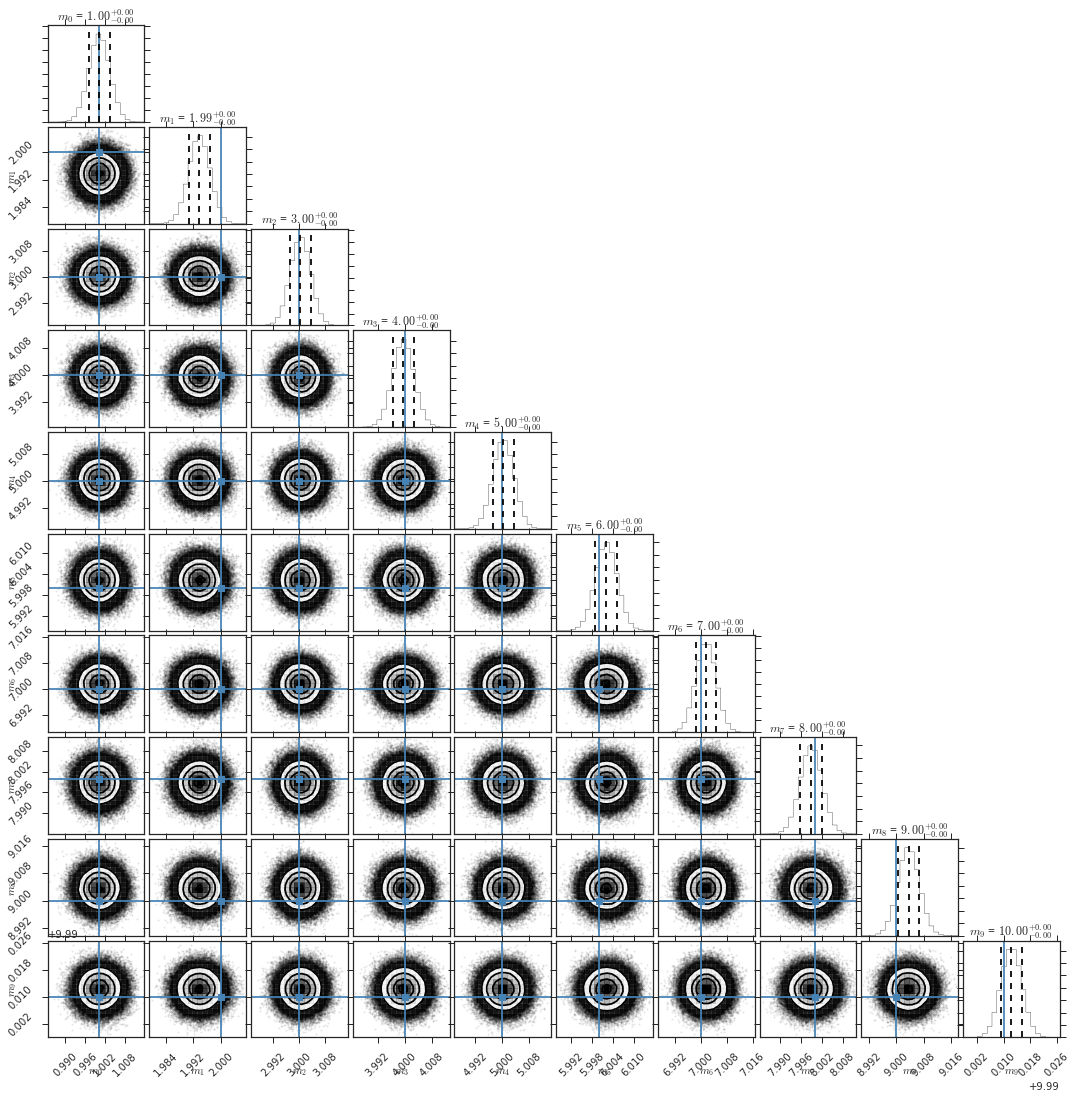

In [178]:
# In the above cell, pystan is intialized
# Running more MCMC steps will be faster 
# 
fit2 = pystan.stan(fit=fit, data=mvgauss_dat, iter=100000, chains=4)
stan_chain=fit2.extract(permuted=True)
if 'mu' in stan_chain.keys(): stan_chain['samples']=stan_chain.pop('mu')
if 'lp__' in stan_chain.keys(): stan_chain['lnprob']=stan_chain.pop('lp__')
print(stan_chain['samples'].shape)

#
gdstans=samples2gdist(stan_chain['samples'],stan_chain['lnprob'],
                     trueval=dmv.mean,px='m')
gdstans.corner()

dictionary of samples and loglike array passed
dimension of chain= 10
(iter,mean,min,max) of LogLikelihood:  0 43.431087067 28.7975476581 47.8795150474
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 5.51604163225 5.46811845114e-22 0.00137866574163 1.37866574163
1199 4 5.30134184159 4.18592123091e-22 0.00110513692758 1.32505917617
1438 4 5.10709010532 3.37289540371e-22 0.000887726421923 1.27655059473
1725 4 4.89875387601 2.83584124724e-22 0.000709861451385 1.22451100364
2069 4 4.93214407245 2.32157757161e-22 0.000595885474501 1.23288704674
2481 4 4.82992705845 1.83706736598e-22 0.000486642524781 1.20736010398
2976 4 4.75539873909 1.50265356678e-22 0.000399445505174 1.1887498234
3569 4 4.67516053985 1.2854363713e-22 0.000327460988993 1.16870826971
4281 4 4.55587708235 1.03576767192e-22 0.000266036617948 1.13890276143
5134 4 4.56020133577 8.76528377325e-23 0.000222048075949 1.13999482192
6158 4 4.54266207128 7.2821953558e-

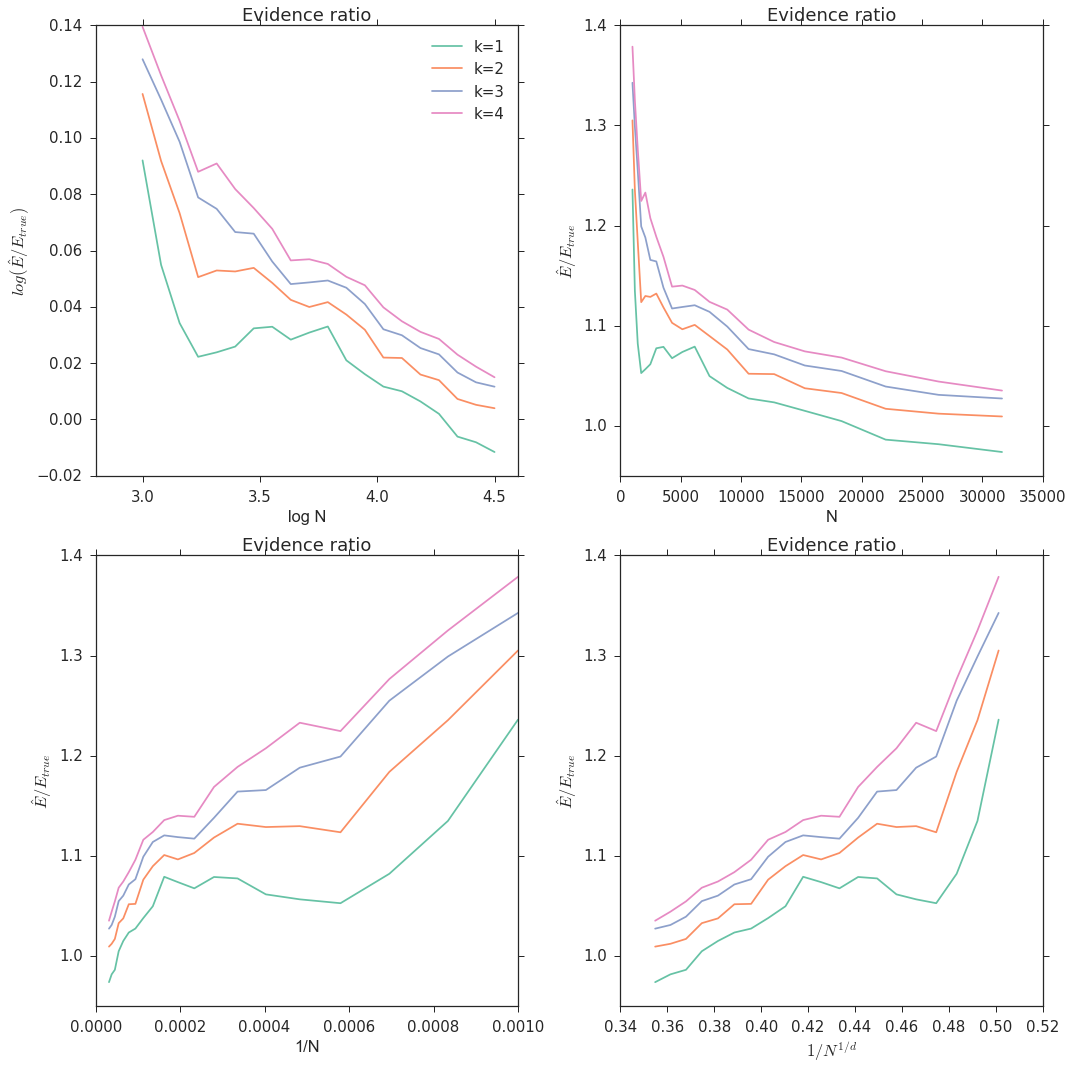

In [198]:
# Here given pystan samples and log probability, we compute evidence ratio 
ealan=eknn.echain(method=stan_chain,verbose=2,ischain=True)
MLE=ealan.chains2evidence() 
ealan.vis_mle(MLE)

## Emcee example

In [164]:
##learn about emcee sampler using help
#help(mec2d.sampler)

## emcee sampling using N-dimensional Gaussian likelihood


mean_sample= [  0.99946486   1.99438161   3.00437903   4.00237726   4.99617213
   5.99771621   7.00400835   7.99598497   9.0006881   10.00171021]
std_sample= [ 1.00179573  0.99993761  0.99821166  1.00006606  0.99963876  1.00109514
  1.00071434  1.00132708  1.00007993  1.00375185]

instance of a model class is passed
emcee total time spent:  5.95624303818
samples shape:  (250000, 10)
dictionary of samples and loglike array passed
dimension of chain= 10
(iter,mean,min,max) of LogLikelihood:  0 43.2162958036 33.2736182554 47.386342381
-------------------- useful intermediate parameter values ------- 
nsample, dotp, median volume, amax, MLE
1000 4 0.073499806205 4.42655507436e-28 1.83703589615e-05 0.0183703589615
1199 4 0.25032161298 1.15282774959e-28 5.21829503814e-05 0.0625673575073
1438 4 0.143852683756 9.62934671339e-29 2.50048120556e-05 0.035956919736
1725 4 0.118460850136 8.11886943879e-29 1.71657513601e-05 0.0296109210961
2069 4 0.121126866122 3.06816938221e-29 1.4634150794e-05 0.0

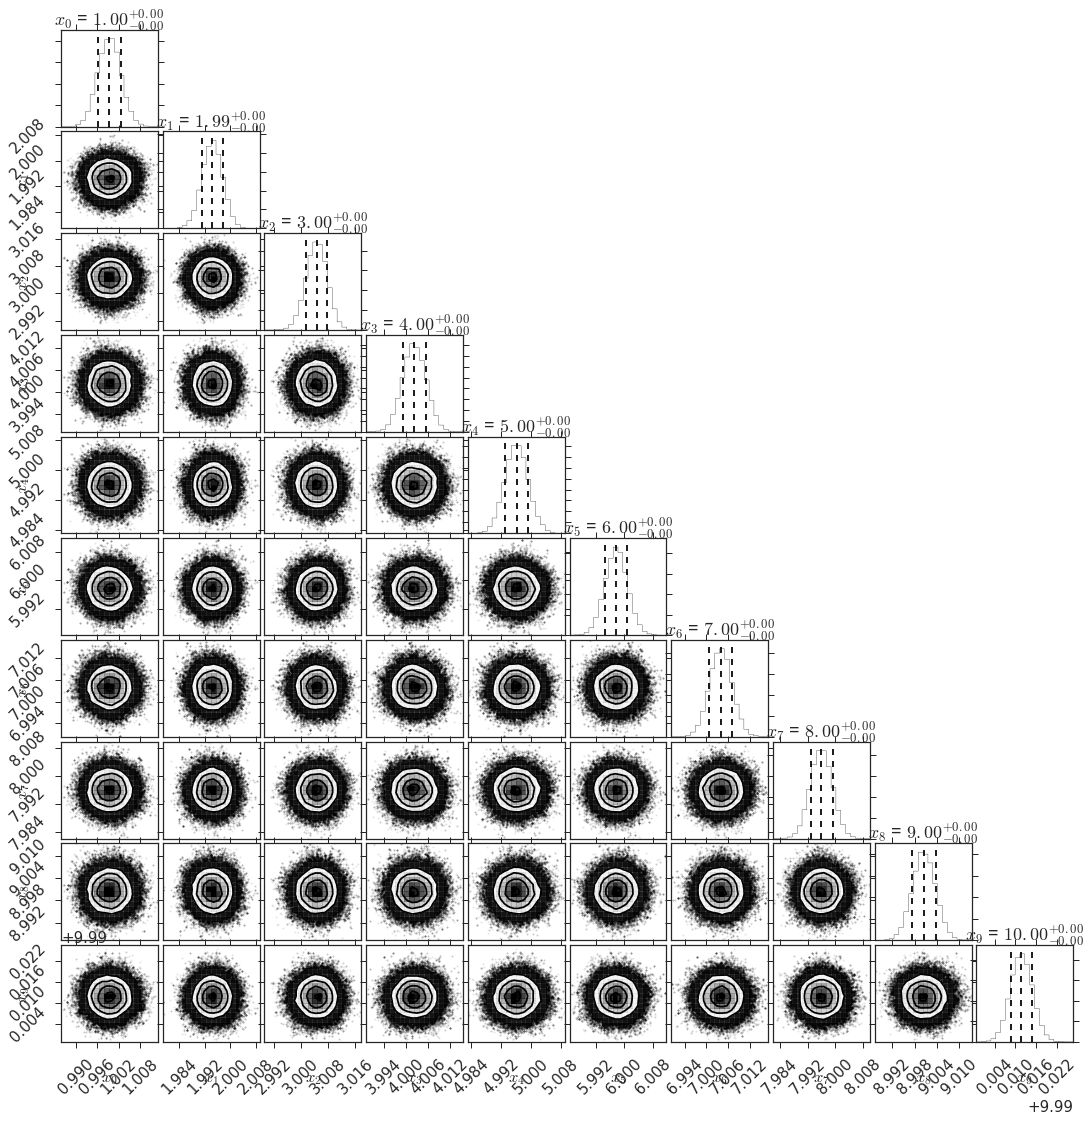

In [197]:
#Evidence calculation based on emcee sampling
mNd=eknn.alan_eg()
mecNd=make_emcee_chain(mNd,nwalkers=500)
samples,lnp=mecNd.mcmc(nmcmc=500)

#corner plot can be done also using getdist wrapper
#getdist wrapper has a lot more functionality than just plotting
gd_mc=samples2gdist(samples,lnp,trueval=mNd.mean,px='m')
gd_mc.corner()

#estimate evidence
ealan=eknn.echain(method={'samples':samples,'lnprob':lnp},verbose=2,ischain=True)
MLE=ealan.chains2evidence() 

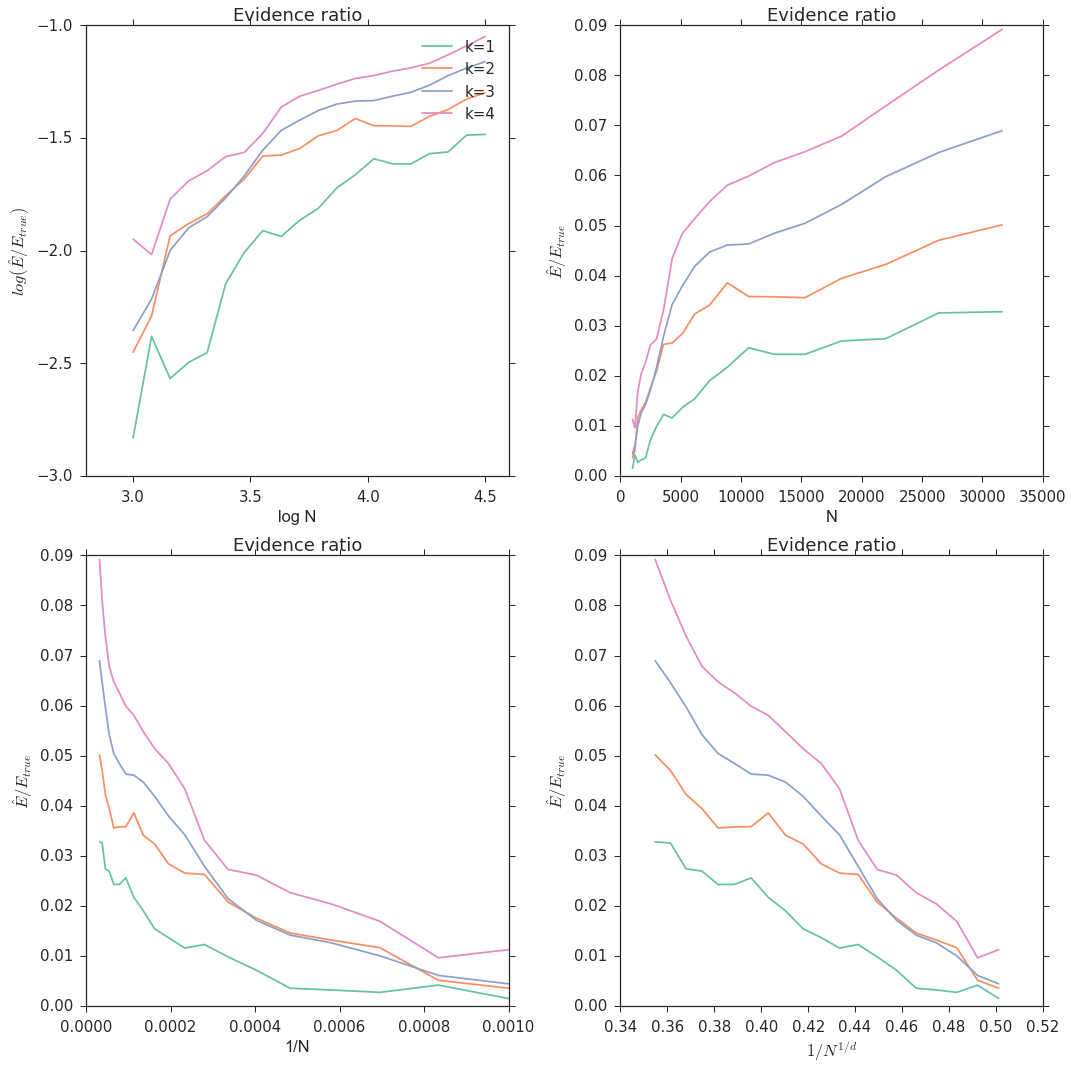

In [196]:
ealan.vis_mle(MLE)

## Emcee 2D example

In [ ]:
#test model class .. visualise uniform sampling
m2d=eknn.model_2d()

#test emcee wrapper 
mec2d=make_emcee_chain(m2d,nwalkers=200)
chain2d,fs=mec2d.mcmc(nmcmc=500)


#let's trangle plot chain samples 
fig = corner.corner(chain2d, labels=["$m$", "$b$"], extents=[[-1.1, -0.8], [3.5, 5.]],
                      truths=m2d.p, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, labels_args={"fontsize": 40})
fig.set_size_inches(10,10)

# Plot back the results in the space of data
#fig = plt.figure()
#xl = np.array([0, 10])
#for m, b in chain2d[np.random.randint(len(chain2d), size=100)]:
#    if m<0:
#        plt.plot(xl, m*xl+b, color="k", alpha=0.1)
    
#plt.plot(xl, m2d.p[0]*xl+m2d.p[1], color="r", lw=2, alpha=0.8)
#plt.errorbar(m2d.x, m2d.y, yerr=m2d.yerr, fmt=".k")
#plt.title('Input Data vs Samples (grey)')
#fig.set_size_inches(12, 8)